# Predict US Inflation

U.S. Inflation: The Price We Pay for Change 💰🔥

Inflation is the silent force that makes your coffee cost more each year. It measures how prices rise over time, affecting everything from groceries to rent. Too high? It erodes your paycheck. Too low? The economy slows down. Policymakers, investors, and everyday consumers keep a close eye on it because inflation shapes interest rates, wages, and financial markets.

Your dataset? A snapshot of history—telling the story of how prices moved across decades.
The dataset contains monthly U.S. inflation rate(over 40 years starting from 1950) data from a source named Mishkin (possibly referencing economist Frederic Mishkin, who has worked on inflation and monetary policy).
https://github.com/lachlandeer/hayashir/blob/master/data-raw/mishkin.csv

In [81]:

# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller


In [82]:
# Load dataset

df = pd.read_csv('data/usinflation.csv')


# Display first few rows
df.head()

,year,month,inflation_1
0,1950,2,-3.552289
1,1950,3,5.247540
2,1950,4,1.692860
3,1950,5,5.064298
4,1950,6,6.719322


In [83]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))

In [84]:
df.head()

,year,month,inflation_1,date
0,1950,2,-3.552289,1950-02-01
1,1950,3,5.247540,1950-03-01
2,1950,4,1.692860,1950-04-01
3,1950,5,5.064298,1950-05-01
4,1950,6,6.719322,1950-06-01


In [85]:

# Set the datetime column as the index
df.set_index('date', inplace=True)
# Drop 'year' and 'month' columns from the DataFrame
df.drop(columns=['year', 'month'], inplace=True)

In [86]:
df.head()

,inflation_1
date,
1950-02-01,-3.552289
1950-03-01,5.247540
1950-04-01,1.692860
1950-05-01,5.064298
1950-06-01,6.719322


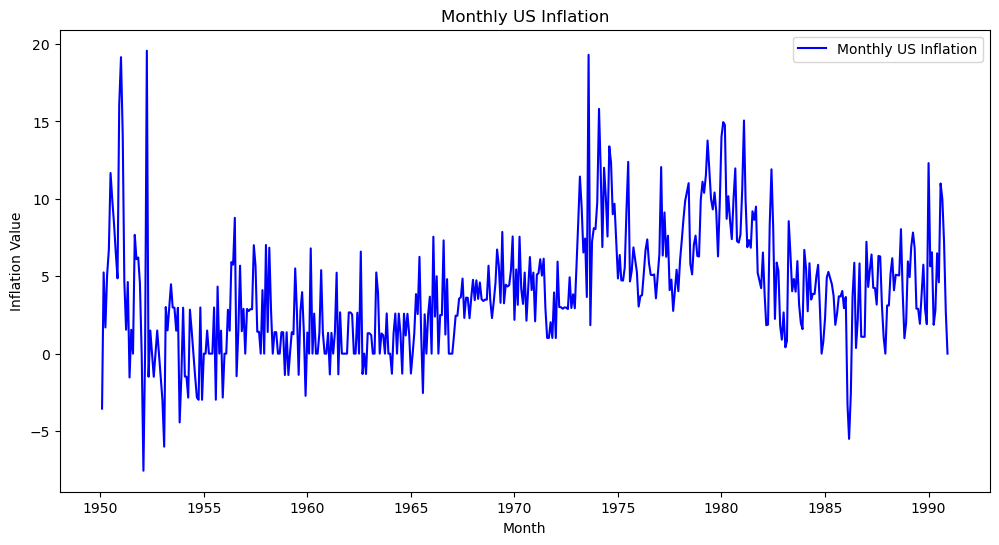

In [87]:
plt.figure(figsize=(12,6))
plt.plot(df, label="Monthly US Inflation", color='blue')
plt.title("Monthly US Inflation")
plt.xlabel("Month")
plt.ylabel("Inflation Value")
plt.legend()
plt.show()

In [88]:
def adf_test(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller (ADF) test on a time series.

    Parameters:
    - series (pd.Series): The time series data to test.
    - alpha (float): Significance level (default is 0.05).

    Returns:
    - None (prints the results)
    """
    result = adfuller(series)

    # Create results dictionary
    output = {
        'Test Statistic': result[0],
        'p-value': result[1],
        '# Lags Used': result[2],
        'Number of Observations': result[3],
    }

    # Add critical values
    for key, value in result[4].items():
        output[f'Critical Value ({key})'] = value

    # Convert to DataFrame for better readability
    output_df = pd.DataFrame(output.items(), columns=['Metric', 'Value'])

    # Print the results
    print("\n🔍 Results of Augmented Dickey-Fuller Test:")
    print(output_df.to_string(index=False))

    # Interpretation
    print("\n📌 Interpretation:")
    if result[1] <= alpha:
        print(f"✅ The time series is **stationary** (p-value = {result[1]:.5f} ≤ {alpha})")
    else:
        print(f"❌ The time series is **not stationary** (p-value = {result[1]:.5f} > {alpha})")

In [89]:
adf_test(df['inflation_1'])


🔍 Results of Augmented Dickey-Fuller Test:
                Metric      Value
        Test Statistic  -2.489327
               p-value   0.118093
           # Lags Used  18.000000
Number of Observations 472.000000
   Critical Value (1%)  -3.444281
   Critical Value (5%)  -2.867683
  Critical Value (10%)  -2.570042

📌 Interpretation:
❌ The time series is **not stationary** (p-value = 0.11809 > 0.05)


In [90]:

#split into train and test sets
X = df.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]

print(f"Training Size: {len(train)} months")
print(f"Test Size: {len(test)} months")

Training Size: 466 months
Test Size: 25 months


In [91]:
# create a differenced series
def trend_differencing(dataset,interval=1):
    diff=list()
    for i in range(interval,len(dataset)):
        value=dataset[i]-dataset[i-interval]
        diff.append(value)
    return np.array(diff)

In [92]:
differenced_series=trend_difference(df['inflation_1'].values,interval=1)

In [93]:
differenced_series

array([ 8.7998290e+00, -3.5546800e+00,  3.3714380e+00,  1.6550240e+00,
        4.9495980e+00, -1.7564190e+00, -1.5657150e+00, -1.8290200e+00,
       -1.6526810e+00,  1.1211236e+01,  3.0779190e+00, -5.0923300e+00,
       -9.4110960e+00, -3.1045040e+00,  3.0807000e+00, -6.1673650e+00,
        3.0807100e+00, -1.5403550e+00,  7.6722570e+00, -1.5696810e+00,
        1.0689600e-01, -1.6763200e+00, -4.5331520e+00, -7.5648660e+00,
        7.5648660e+00,  1.9570490e+01, -2.1064641e+01,  2.9883020e+00,
       -1.4941510e+00, -1.4941510e+00,  1.4941510e+00,  1.4941510e+00,
       -1.4941510e+00, -1.4941510e+00, -1.4997430e+00, -3.0163970e+00,
        9.0191990e+00, -1.5072780e+00,  1.4960040e+00,  1.4848230e+00,
       -1.5034280e+00, -7.4800000e-03, -1.4884780e+00,  1.4775840e+00,
       -7.4043810e+00,  2.9588200e+00,  4.4528840e+00, -4.4510490e+00,
       -1.8350000e-03, -1.3550000e+00,  5.6798120e+00, -1.3550000e+00,
       -1.4849060e+00, -1.4849060e+00, -1.3550000e+00, -1.4238500e-01,
      

In [94]:
adf_test(differenced_series)


🔍 Results of Augmented Dickey-Fuller Test:
                Metric         Value
        Test Statistic -5.946907e+00
               p-value  2.193241e-07
           # Lags Used  1.800000e+01
Number of Observations  4.710000e+02
   Critical Value (1%) -3.444310e+00
   Critical Value (5%) -2.867696e+00
  Critical Value (10%) -2.570049e+00

📌 Interpretation:
✅ The time series is **stationary** (p-value = 0.00000 ≤ 0.05)


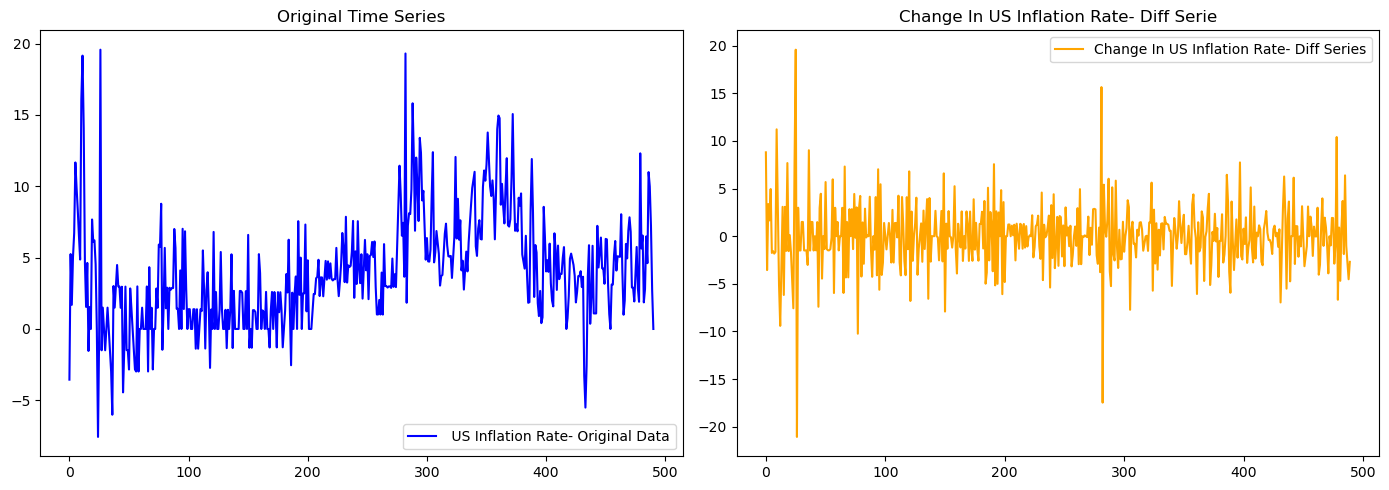

In [95]:
# plot before and after series
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original series
axes[0].plot(df['inflation_1'].values, label=' US Inflation Rate- Original Data', color='blue')
axes[0].set_title('Original Time Series')
axes[0].legend()

# Diff transformed series
axes[1].plot(differenced_series, label="Change In US Inflation Rate- Diff Series", color='orange')
axes[1].set_title('Change In US Inflation Rate- Diff Serie')
axes[1].legend()

plt.tight_layout()
plt.show()

In [96]:
len(df['inflation_1'])

491

In [97]:
len(differenced_series)

490

In [98]:
#split into train and test sets
X_diff = differenced_series
size = int(len(X) * 0.95)
train_diff, test_diff = X_diff[0:size], X_diff[size:len(X)]

print(f"Training Size: {len(train_diff)} ")
print(f"Test Size: {len(test_diff)}")

Training Size: 466 
Test Size: 24


In [99]:
# ACF and PACF function to plot both Autocorrelation and Partial Autocorrelation
def ACF_and_PACF(data):
    # Create a figure with a specific size (12x9 inches)
    fig = plt.figure(figsize=(12,9))

    # Add subplot for ACF (Autocorrelation Function)
    ax1 = fig.add_subplot(211)  
    fig = plot_acf(data, lags=40, ax=ax1)  

    # Add subplot for PACF (Partial Autocorrelation Function)
    ax2 = fig.add_subplot(212) 
    fig = plot_pacf(data, lags=30, ax=ax2)  

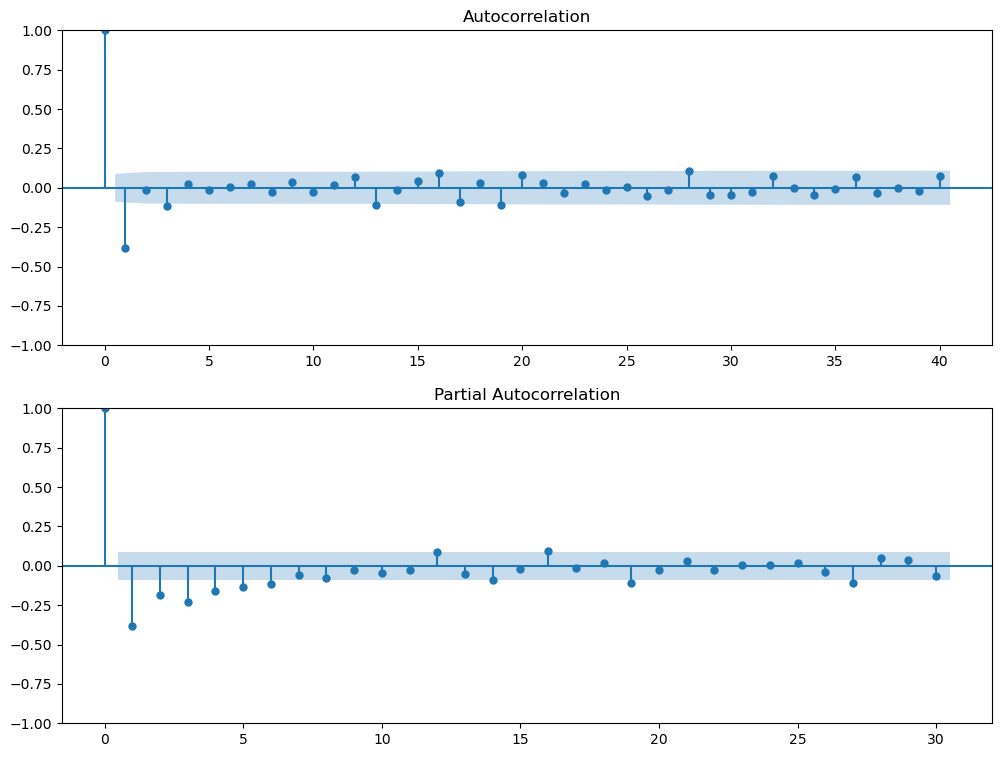

In [100]:
#Call the ACF_and_PACF function for the transformed train data
ACF_and_PACF(differenced_series)

In [101]:
model=ARIMA(train_diff,order=(1,0,3))


In [102]:
model_fit=model.fit()

In [103]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  466
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1158.112
Date:                Thu, 27 Feb 2025   AIC                           2328.224
Time:                        12:39:27   BIC                           2353.089
Sample:                             0   HQIC                          2338.010
                                - 466                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0023      0.025     -0.092      0.927      -0.052       0.047
ar.L1         -0.4360      0.343     -1.269      0.204      -1.109       0.237
ma.L1         -0.2050      0.341     -0.601      0.5

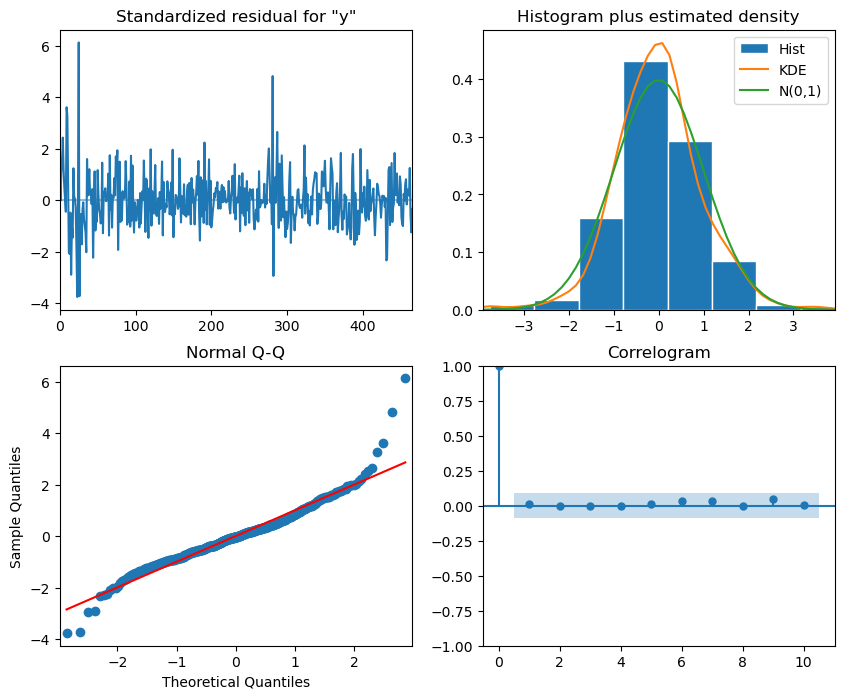

In [104]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [132]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize variables
history_original = list(train)  # Start with the original training data
history = list(train_diff)  # Start with the differenced training data
predictions = []
actual_values = []  # Store actual values for evaluation

for t in range(len(test_diff)):
    # Fit ARIMA model to the differenced series
    model = ARIMA(history, order=(2, 0, 3))  
    model_fit = model.fit()
    
    # Forecast the differenced value
    yhat_diff = model_fit.forecast()[0]
    
    # Inverse differencing to get the prediction on the original scale
    yhat = history_original[-1] + yhat_diff  # Add the last observed value to the differenced forecast
    
    predictions.append(yhat)  # Store the prediction in original scale
    
    # Get the actual value from the original test set (not differenced)
    obs = test[t]  # The original value from the test set (not differenced)
    actual_values.append(obs)  # Store actual value for evaluation
    
    # Append the actual differenced value to history for the next iteration
    history.append(test_diff[t])  # Add the actual differenced value to the history
    history_original.append(test[t])
    
    # Print prediction and actual observed value
    print(f"Predicted={yhat}, Actual={obs}")


    

Predicted=[2.46533196], Actual=[1.993322]
Predicted=[0.79585796], Actual=[5.960278]
Predicted=[5.54413518], Actual=[4.944349]
Predicted=[3.09072068], Actual=[6.888122]
Predicted=[5.00123655], Actual=[7.823956]
Predicted=[6.63320516], Actual=[6.804426]
Predicted=[8.24509395], Actual=[2.904398]
Predicted=[4.11800563], Actual=[2.897386]
Predicted=[4.79657282], Actual=[1.927679]
Predicted=[2.15621638], Actual=[3.84619]
Predicted=[3.03661516], Actual=[5.74622]
Predicted=[6.76282312], Actual=[2.862824]
Predicted=[4.16885147], Actual=[1.90473]
Predicted=[-3.3570007], Actual=[12.30783]
Predicted=[12.29940543], Actual=[5.638225]
Predicted=[4.02199959], Actual=[6.544558]
Predicted=[9.21207895], Actual=[1.863323]
Predicted=[2.86678214], Actual=[2.789618]
Predicted=[1.75873702], Actual=[6.484031]
Predicted=[6.7609568], Actual=[4.61004]
Predicted=[0.35367642], Actual=[10.99254]
Predicted=[8.56309823], Actual=[9.988676]
Predicted=[9.04154883], Actual=[7.212614]
Predicted=[9.4597705], Actual=[2.69369

In [133]:
# Performance Evaluation
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)

print("\nPerformance Metrics:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


Performance Metrics:
MAE: 3.8679840969205355
MSE: 27.49490945352274
RMSE: 5.243558853824637


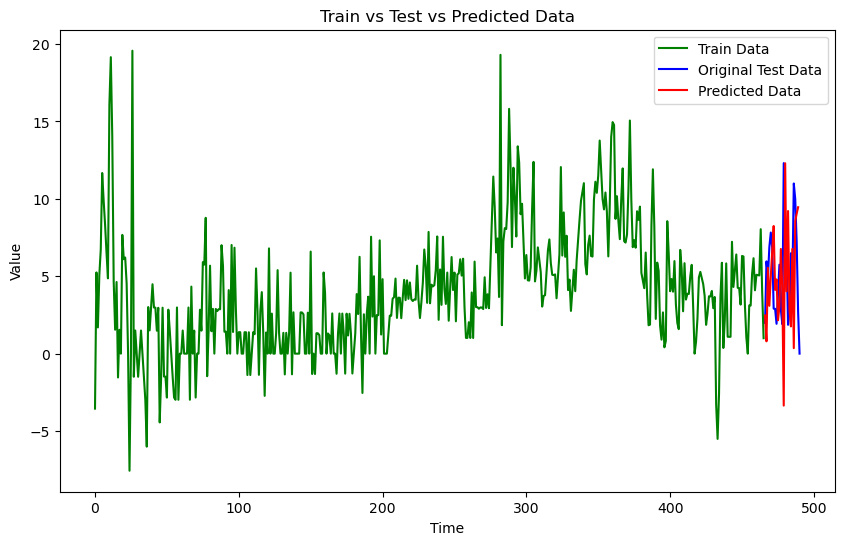

In [134]:
import matplotlib.pyplot as plt

# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Plot the train data (the original training data)
plt.plot(range(len(train)), train, label='Train Data', color='green', linestyle='-')

# Plot the original test data (the actual values)
plt.plot(range(len(train), len(train) + len(test)), test, label='Original Test Data', color='blue', linestyle='-')

# Plot the predicted data (the original scale after inverse differencing)
plt.plot(range(len(train), len(train) + len(predictions)), predictions, label='Predicted Data', color='red', linestyle='-')

# Add labels and title
plt.title('Train vs Test vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()



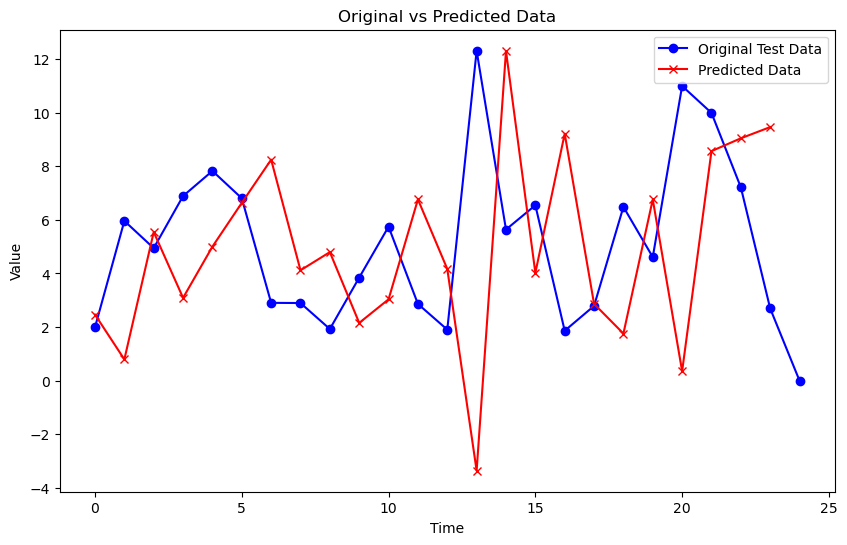

In [135]:
import matplotlib.pyplot as plt

# Initialize the figure for plotting
plt.figure(figsize=(10, 6))

# Plot the original test data (the original scale)
plt.plot(test, label='Original Test Data', color='blue', linestyle='-', marker='o')

# Plot the predicted data (the original scale after inverse differencing)
plt.plot(predictions, label='Predicted Data', color='red', linestyle='-', marker='x')

# Add labels and title
plt.title('Original vs Predicted Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()